## Data Set Preparation

In [1]:

import os
import cv2

def resize_and_preserve_aspect_ratio(image_path, target_size, output_path):
    # Resize an image to the target size while preserving aspect ratio.
    try:
        img = cv2.imread(image_path)  # Read the image in color mode (default)
        if img is None:
            print(f"Error: Unable to read {image_path}")
            return

        # Get original dimensions
        original_height, original_width = img.shape[:2]
        target_width, target_height = target_size

        # Calculate the scaling factors
        scale_width = target_width / original_width
        scale_height = target_height / original_height
        scale = min(scale_width, scale_height)

        # Compute the new dimensions
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize the image
        resized_img = cv2.resize(
            img, (new_width, new_height),
            interpolation=cv2.INTER_CUBIC if scale > 1 else cv2.INTER_AREA
        )

        # Add padding to achieve the exact target size
        delta_w = target_width - new_width
        delta_h = target_height - new_height
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        padded_img = cv2.copyMakeBorder(
            resized_img, top, bottom, left, right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
        )

        # Save the resized image
        cv2.imwrite(output_path, padded_img)
        print(f"Resized and saved: {output_path}")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def resize_images_in_folder(input_folder, output_folder, target_size):
    # Resize all images in the input folder and save them to the output folder.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            input_path = os.path.join(root, file)
            output_path = os.path.join(output_folder, file)
            resize_and_preserve_aspect_ratio(input_path, target_size, output_path)

if __name__ == "__main__":
    # Define input and output folders
    input_happy = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\happy"
    input_sad = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\sad"
    output_happy = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
    output_sad = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_sad"

    # Define target size
    target_size = (128, 128)  # Change to your desired resolution

    print("\nResizing Happy images...")
    resize_images_in_folder(input_happy, output_happy, target_size)

    print("\nResizing Sad images...")
    resize_images_in_folder(input_sad, output_sad, target_size)

    print("\nResizing process completed.")



Resizing Happy images...
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\-41604787097oijary3e0b.png
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\-cheerful-african-american-black-male-happy-expressive-smiley-face-197149245.jpg
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\05-12-21-happy-people.jpg
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\1000_F_185048528_i9zX0FC3Q8iDNb2E5hanWzN0KeJSXSy6.jpg
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\1000_F_206825373_PfhE4TyHbpUXggBKdTLZYn0HcuRCP9rf.jpg
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\1000_F_246149544_RZIU2J7fQKl9JVWZBeSvJHUCRtdjTqAl.jpg
Resized and saved: C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy\1000_F_254262588_wbdwGWgnETRzXZo49JBRLfkjnUybShBE.jpg
Resized and saved: C:\Users\k

## Checking if the dataset is balanced

In [2]:
import os

def count_images(folder):
    """Count the number of images in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Define folder paths
happy_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_sad"

# Count images in each folder
happy_count = count_images(happy_folder)
sad_count = count_images(sad_folder)

print(f"Number of Happy images: {happy_count}")
print(f"Number of Sad images: {sad_count}")

# Check if the dataset is balanced
if happy_count != sad_count:
    print("Warning: The dataset is imbalanced!")
    if happy_count > sad_count:
        print(f"The Happy class has {happy_count - sad_count} more images than the Sad class.")
    else:
        print(f"The Sad class has {sad_count - happy_count} more images than the Happy class.")
else:
    print("The dataset is balanced.")


Number of Happy images: 589
Number of Sad images: 491
The Happy class has 98 more images than the Sad class.


## Balancing the Dataset 
    Will do Oversample for the "Sad" class

In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(input_folder, output_folder, target_count):
    """
    Augment images in the input folder until the target count is reached.
    Parameters:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder where augmented images will be saved.
        target_count (int): The desired total number of images.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Load all files in the input folder
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    current_count = len(files)
    print(f"Current number of images: {current_count}")

    while current_count < target_count:
        for file in files:
            img_path = os.path.join(input_folder, file)
            img = cv2.imread(img_path)

            if img is not None:
                img = np.expand_dims(img, axis=0)  # Add batch dimension

                for batch in datagen.flow(img, batch_size=1, save_to_dir=output_folder, save_prefix="aug", save_format="jpg"):
                    current_count += 1
                    if current_count >= target_count:
                        break
            else:
                print(f"Error loading image: {img_path}")

    print(f"Augmented images to reach {target_count} images in total.")

# Define paths for "Sad" class
sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_sad"  # Path to original "Sad" images
augmented_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\augmented_sad"  # Path to save augmented images

# Target count for balancing
target_count = 589  # Match "Happy" class count

# Run the augmentation
augment_images(sad_folder, augmented_sad_folder, target_count)


Current number of images: 491
Augmented images to reach 589 images in total.


## Verifying Counts after increasing "Sad"

In [4]:
def count_images(folder):
    """Count the number of images in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Paths
happy_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
augmented_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\augmented_sad"

# Count images
happy_count = count_images(happy_folder)
sad_count = count_images(augmented_sad_folder)

print(f"Number of Happy images: {happy_count}")
print(f"Number of Sad images: {sad_count}")


Number of Happy images: 589
Number of Sad images: 568


Still dataset is not balanced

In [5]:
def augment_missing_images(input_folder, output_folder, target_count):
    """
    Augment additional images in the input folder to reach the target count.
    Parameters:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder where augmented images will be saved.
        target_count (int): The desired total number of images.
    """
    # Get current number of images
    files = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]
    current_count = len(files)
    print(f"Current number of augmented images: {current_count}")

    if current_count >= target_count:
        print("No additional augmentation needed.")
        return

    # Initialize data generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    while current_count < target_count:
        for file in files:
            img_path = os.path.join(input_folder, file)
            img = cv2.imread(img_path)

            if img is not None:
                img = np.expand_dims(img, axis=0)  # Add batch dimension

                for batch in datagen.flow(img, batch_size=1, save_to_dir=output_folder, save_prefix="aug", save_format="jpg"):
                    current_count += 1
                    if current_count >= target_count:
                        break
            else:
                print(f"Error loading image: {img_path}")

    print(f"Added {target_count - len(files)} more images to reach {target_count} images in total.")

# Run the augmentation process again for missing images
sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_sad"
augmented_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\augmented_sad"

target_count = 589  # Match "Happy" class count
augment_missing_images(sad_folder, augmented_sad_folder, target_count)


Current number of augmented images: 568
Added 98 more images to reach 589 images in total.


verify dataset 

In [6]:
def count_images(folder):
    """Count the number of images in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Paths
happy_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
augmented_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\augmented_sad"

# Count images
happy_count = count_images(happy_folder)
sad_count = count_images(augmented_sad_folder)

print(f"Number of Happy images: {happy_count}")
print(f"Number of Sad images: {sad_count}")

Number of Happy images: 589
Number of Sad images: 1048


Fix oversampling

In [8]:
import os
import shutil
import random

def undersample_folder(input_folder, output_folder, target_count):
    """
    Randomly select a target number of images from the input folder and copy them to the output folder.
    Parameters:
        input_folder (str): Path to the folder with oversampled images.
        output_folder (str): Path to the folder for saving the undersampled dataset.
        target_count (int): The desired number of images.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get all image files
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    if len(files) <= target_count:
        print("No undersampling needed. The number of images is already within the target count.")
        return

    # Randomly select the target number of files
    selected_files = random.sample(files, target_count)

    # Copy selected files to the output folder
    for file in selected_files:
        src_path = os.path.join(input_folder, file)
        dest_path = os.path.join(output_folder, file)
        shutil.copy2(src_path, dest_path)

    print(f"Undersampled {len(selected_files)} images to {output_folder}.")

# Paths for "Sad" class
oversampled_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\augmented_sad"
undersampled_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\balanced_sad"

# Target count for balancing
target_count = 589  # Match "Happy" class count

# Run the undersampling
undersample_folder(oversampled_sad_folder, undersampled_sad_folder, target_count)


Undersampled 589 images to C:\Users\kalop\CV-Project\HappyorSadPrediction\data\balanced_sad.


In [9]:
def count_images(folder):
    """Count the number of images in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Paths
happy_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
augmented_sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\balanced_sad"

# Count images
happy_count = count_images(happy_folder)
sad_count = count_images(augmented_sad_folder)

print(f"Number of Happy images: {happy_count}")
print(f"Number of Sad images: {sad_count}")

Number of Happy images: 589
Number of Sad images: 589


## Splitting Dataset

In [23]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_and_organize_dataset(source_folder, output_base_folder, class_name, train_ratio=0.7, val_ratio=0.15):
    """
    Splits images from a single source folder into train, val, and test sets, 
    and organizes them into class-specific subdirectories.
    
    Parameters:
        source_folder (str): Path to the folder containing all images of one class.
        output_base_folder (str): Base path for the train, val, and test directories.
        class_name (str): Name of the class (e.g., "Happy" or "Sad").
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
    """
    # Ensure base directories exist
    train_folder = os.path.join(output_base_folder, "train", class_name)
    val_folder = os.path.join(output_base_folder, "val", class_name)
    test_folder = os.path.join(output_base_folder, "test", class_name)

    for folder in [train_folder, val_folder, test_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Get all image files
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    # Split into train, val, and test sets
    train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=val_ratio / (1 - train_ratio), random_state=42)

    # Move files to their respective directories
    for file_list, folder in zip([train_files, val_files, test_files], [train_folder, val_folder, test_folder]):
        for file in file_list:
            src_path = os.path.join(source_folder, file)
            dest_path = os.path.join(folder, file)
            shutil.copy2(src_path, dest_path)

# Paths to the datasets
happy_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\resized_happy"
sad_folder = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data\balanced_sad"

# Base output path for data split
output_base = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data_split"

# Split the "Happy" and "Sad" datasets
print("Splitting Happy dataset...")
split_and_organize_dataset(happy_folder, output_base, "Happy")

print("\nSplitting Sad dataset...")
split_and_organize_dataset(sad_folder, output_base, "Sad")

print("\nDataset splitting and organization complete!")


Splitting Happy dataset...

Splitting Sad dataset...

Dataset splitting and organization complete!


Verify dataset split: 

In [24]:
output_base = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data_split"
print("Checking training set:")
check_combined_directory(os.path.join(output_base, "train"))
print("\nChecking validation set:")
check_combined_directory(os.path.join(output_base, "val"))
print("\nChecking test set:")
check_combined_directory(os.path.join(output_base, "test"))


Checking training set:
Class 'Happy': 412 images
Class 'Sad': 412 images

Checking validation set:
Class 'Happy': 88 images
Class 'Sad': 88 images

Checking test set:
Class 'Happy': 89 images
Class 'Sad': 89 images


## Building and Traning the Model
### CNN to classify the images

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Paths to training, validation, and test sets
train_dir = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data_split\train"
val_dir = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data_split\val"

# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only normalize for validation and test sets

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"  # Binary classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Build the CNN model with L2 regularization and dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Train for up to 20 epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Save the model
model.save(r"C:\Users\kalop\CV-Project\HappyorSadPrediction\happy_sad_model_regularized.keras")

print("Model training completed and saved!")


Found 824 images belonging to 2 classes.
Found 176 images belonging to 2 classes.


c:\Users\kalop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\kalop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.4927 - loss: 3.3854 - val_accuracy: 0.5000 - val_loss: 1.5841
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.7082 - loss: 1.3323 - val_accuracy: 0.8239 - val_loss: 0.8189
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.8455 - loss: 0.7794 - val_accuracy: 0.8807 - val_loss: 0.5848
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.8646 - loss: 0.6363 - val_accuracy: 0.9034 - val_loss: 0.4580
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.8975 - loss: 0.5138 - val_accuracy: 0.8977 - val_loss: 0.4364
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.8999 - loss: 0.4766 - val_accuracy: 0.9375 - val_loss: 0.3703
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.8857 - loss: 0.4803 - val_accuracy: 0.9261 - val_loss: 0.3563
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.8897 - loss: 0.4459 - val_accu

Visualization 

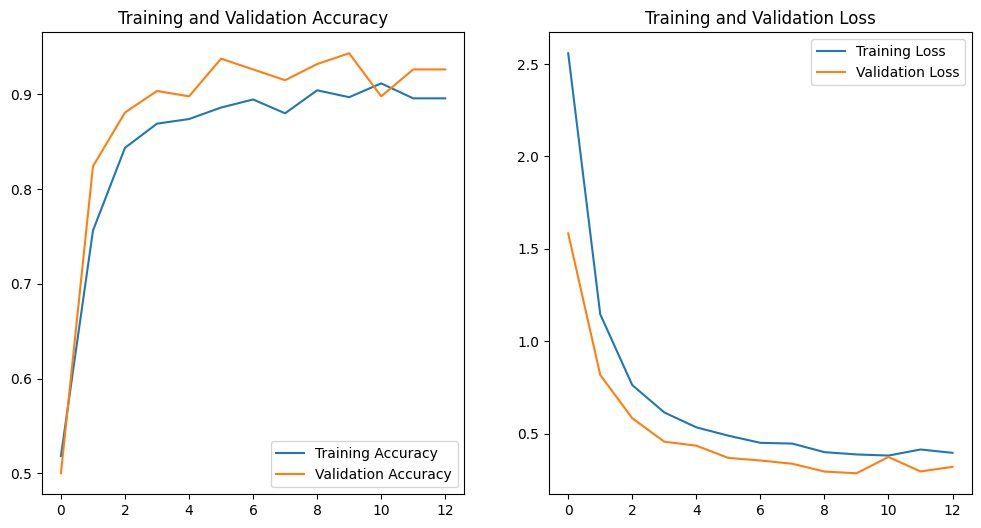

In [28]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create epochs range
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.show()


## Evaluate Model on the Test Set

In [29]:
# Evaluate the model on the test set
test_dir = r"C:\Users\kalop\CV-Project\HappyorSadPrediction\data_split\test"

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 178 images belonging to 2 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.9281 - loss: 0.3373
Test Accuracy: 94.38%
Test Loss: 0.3241


## Visualize Misclassifications

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


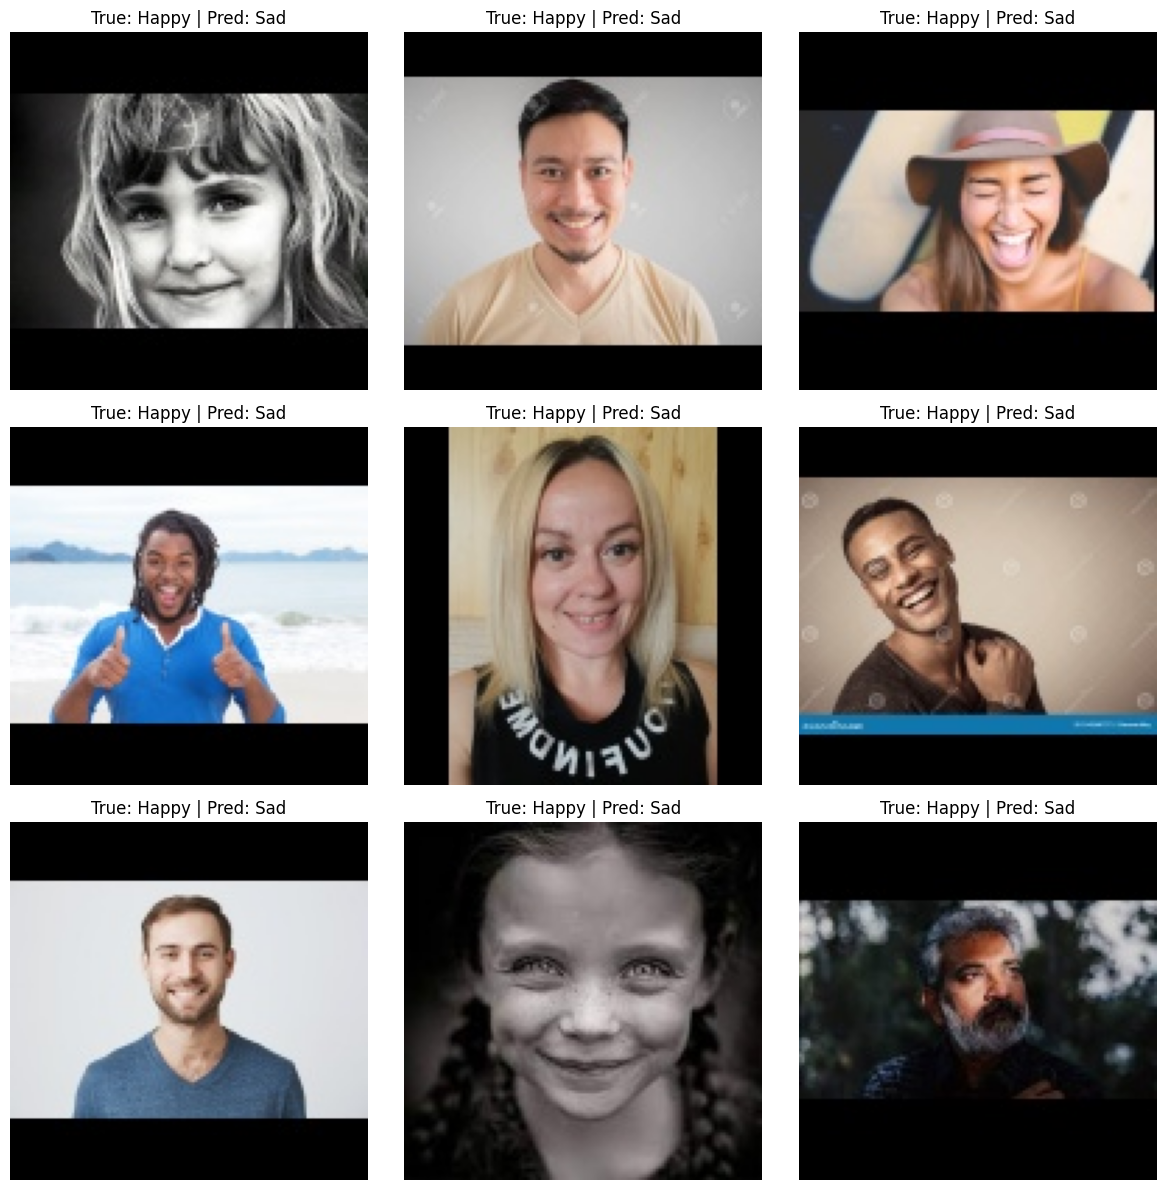

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the test generator
test_generator.reset()  # Reset generator to start from the first batch
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Find misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot some misclassified examples
plt.figure(figsize=(12, 12))
for i, index in enumerate(misclassified_indices[:9]):  # Display up to 9 misclassified examples
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)
    true_label = true_classes[index]
    pred_label = predicted_classes[index]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]} | Pred: {class_labels[pred_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Deploying in Streamlit

In [1]:
streamlit_code = """
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image

# Path to your saved model
MODEL_PATH = r"C:\\Users\\kalop\\CV-Project\\HappyorSadPrediction\\happy_sad_model_regularized.keras"

# Load the trained model
model = load_model(MODEL_PATH)

# Constants for image preprocessing
IMG_HEIGHT = 128
IMG_WIDTH = 128
CLASS_NAMES = ["Sad", "Happy"]

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match model input
    image = img_to_array(image)  # Convert to array
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image / 255.0  # Normalize pixel values
    return image

# Streamlit UI
st.title("Happy or Sad Emotion Detector")
st.write("Upload an image, and the model will predict whether the emotion is Happy or Sad.")

# File uploader
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)

    # Process the image
    image = Image.open(uploaded_file)
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)[0][0]
    predicted_class = CLASS_NAMES[int(prediction > 0.5)]
    confidence = prediction if predicted_class == "Happy" else 1 - prediction

    # Display the result
    st.write(f"Prediction: **{predicted_class}**")
    st.write(f"Confidence: **{confidence * 100:.2f}%**")
"""

# Save the Streamlit code to a file
with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit app saved as 'app.py'.")


Streamlit app saved as 'app.py'.


In [ ]:
import os
import subprocess

# Launch the Streamlit app
def launch_streamlit():
    app_path = os.path.join(os.getcwd(), "app.py")  # Ensure the app is saved in the current directory
    subprocess.run(["streamlit", "run", app_path], check=True)

# Launch the app
launch_streamlit()
